# Import libs

In [64]:
import pandas as pd
import seaborn as sns
import numpy as np

# Read data

In [65]:
df=pd.read_csv('laptops_.csv')

In [66]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


# Small EDA

In [67]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   laptop        2160 non-null   object 
 1   status        2160 non-null   object 
 2   brand         2160 non-null   object 
 3   model         2160 non-null   object 
 4   cpu           2160 non-null   object 
 5   ram           2160 non-null   int64  
 6   storage       2160 non-null   int64  
 7   storage_type  2118 non-null   object 
 8   gpu           789 non-null    object 
 9   screen        2156 non-null   float64
 10  touch         2160 non-null   object 
 11  final_price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


In [69]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

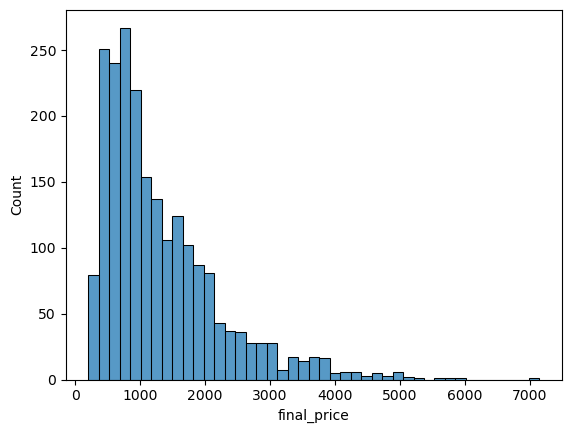

In [70]:
sns.histplot(data=df, x ='final_price');

In [71]:
df.isna().sum()

laptop             0
status             0
brand              0
model              0
cpu                0
ram                0
storage            0
storage_type      42
gpu             1371
screen             4
touch              0
final_price        0
dtype: int64

In [72]:
df.describe()

,ram,storage,screen,final_price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


# Train test split

In [73]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [74]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [75]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [76]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [77]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [78]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [79]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [80]:
len(y_train)

1296

# Data prep

In [81]:
def prepare_X(df,base,value=0):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [82]:
base = df_train.select_dtypes(exclude='object').columns

In [83]:
base

Index(['ram', 'storage', 'screen'], dtype='object')

# Training a model

In [84]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [85]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [86]:
X_train = prepare_X(df_train,base)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val,base)
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

597.36

In [87]:
df_train.screen.mean()

15.163534416086618

In [88]:
X_train = prepare_X(df_train,base,value=df_train.screen.mean())
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val,base,value=df_train.screen.mean())
y_pred = w0 + X_val.dot(w)
round(rmse(y_val, y_pred),2)

597.36

# Regularization

In [89]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [90]:
X_train = prepare_X(df_train,base)
X_val = prepare_X(df_val,base)

In [91]:
for r in [0.0, 0.01,0.1,1,5,10,100]:
    X_train = prepare_X(df_train,base)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val,base)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred),5)
    
    print(r, w0, score)

0.0 676.8954853003471 597.36356
0.01 676.2736817204672 597.36168
0.1 670.7284836313021 597.34516
1 619.9030834107807 597.21212
5 463.77716971415225 597.01112
10 352.79713367676436 597.05877
100 66.92071440180734 597.90326


# Different seeds

In [111]:
rmse_list=[]

In [112]:
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    np.random.shuffle(idx)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train=df_train.final_price.values
    y_val=df_val.final_price.values
    y_test =df_test.final_price.values
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    X_train = prepare_X(df_train,base)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val,base)
    y_pred = w0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))
round(np.std(rmse_list),3)

26.339

In [113]:
rmse_list

[599.2847664347933,
 575.5232813909296,
 552.5791996870215,
 545.2406407170806,
 623.1252754469972,
 595.9325260866881,
 587.5501286558233,
 614.1887728640678,
 627.0761517285292,
 604.1504717583197]

# Regulzarize prediction

In [134]:
n = len(df)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

In [135]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [136]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [137]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [138]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [139]:
df_full = pd.concat([df_train,df_val])

In [140]:
y_full = df_full.final_price.values
y_test = df_test.final_price.values

In [141]:
del df_full['final_price']
del df_test['final_price']

In [142]:
X_full = prepare_X(df_full,base)
X_test = prepare_X(df_test,base)

In [143]:
w0, w = train_linear_regression_reg(X_full, y_full, r=0.001)

In [144]:
y_pred = w0 + X_test.dot(w)
score = round(rmse(y_test, y_pred),5)

In [145]:
score

608.60998